In [1]:
#!/usr/bin/python

import numpy as np
import pyfits
import os
from matplotlib import pyplot as plt

import delta_r_utils as utils
import shearcode_modules as shear
import environment_utils as envutils

import astropy.units as u

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib import rc, rcParams

inf = np.inf

# Make use of TeX
rc('text',usetex=True)

# Change all fonts to 'Computer Modern'
rc('font',**{'family':'serif','serif':['Computer Modern']})

path_gamacats = '/data2/brouwer/MergedCatalogues'
gamacatname = '%s/GAMACatalogue_1.0.fits'%path_gamacats
shuffledcatname = '%s/shuffled_environment_S4_deltaR.fits'%path_gamacats
path_results = 'results'

centering = 'BCG'
purpose = 'shearcatalog'
Ncat = 1
Runit = 'kpc'
lens_weights = {'None': ''}

O_matter = 0.315
O_lambda = 1.-O_matter
Ok = 0.
h = 1.

In [2]:
rankmin = -999
rankmax = inf

shuffled = False

envnames = ['Void', 'Sheet', 'Filament', 'Knot']
#envcolors = ['red', 'green', 'blue', 'orange']
#envcolors = ['#332288', '#88CCEE', '#CC6677', '#882255'] # figure 1
envcolors = ['#114477', '#44AAAA', '#AA7744', '#771122'] # figure 2
#envcolors = ['#CC6677', '#117733', '#4477AA', '#DDCC77'] # figure 3


#332288 blue
#88CCEE light blue
#44AA99 turquoise
#117733 green
#999933 beige
#DDCC77 yellow
#CC6677 light red
#882255 purple
#AA4499 pink

#DDCC77 yellow
#4477AA blue
#117733 green
#CC6677 red

#114477 blue - void
#44AAAA cyan - sheet
#AA7744 orange - filament
#771122 red - knot

In [4]:
# Importing catalogues

# Shuffled environment catalogue
shuffledcat = pyfits.open(shuffledcatname)[1].data
shuffenvlist =  shuffledcat['shuffenvR4'] # Shuffled environment of the galaxy (0 void, 1 sheet, 2 filament, 3 knot)

# Local density catalogue
deltacatname = '%s/delta_r_catalog.fits'%path_gamacats
deltacat = pyfits.open(deltacatname)[1].data
deltaRlist = deltacat['delta_R4']

# GAMA catalogue
gamacat, galIDlist, RAlist, DEClist, galweightlist, galZlist, Dcllist, Dallist = \
shear.import_gamacat(gamacatname, centering, purpose, Ncat, \
O_matter, O_lambda, Ok, h, Runit, lens_weights)

Dcllist *= u.pc
Dallist *= u.pc

# Importing angular seperation
angseplist = gamacat['AngSep%s'%centering]
angseplist[angseplist<=0] = 0.

# Importing and correcting log(Mstar)
logmstarlist = gamacat['logmstar']
fluxscalelist = gamacat['fluxscale'] # Fluxscale, needed for stellar mass correction
corr_list = np.log10(fluxscalelist)# - 2*np.log10(h/0.7)
logmstarlist = logmstarlist + corr_list
nQlist = gamacat['nQ'] # nQ of all galaxies
ranklist = gamacat['rankBCG']
zlist =  gamacat['Z']

# Defining the color (g-r)0
petrolist = gamacat['Rpetro'] # petrosian magnitude of all galaxies
gmaglist = gamacat['absmag_g'] # g magnitude of all galaxies
rmaglist = gamacat['absmag_r'] # r magnitude of all galaxies
colorlist = gmaglist-rmaglist
maglist = utils.calc_magnitude(zlist, Dcllist, colorlist, petrolist)

if not shuffled:
    # Importing the real environment
    envlist = gamacat['envS4']
else:
    # Importing the shuffled environment
    envlist = shuffledcat['shuffenvR4']

# Applying a mask to the galaxies
obsmask = (fluxscalelist<500)&(logmstarlist>5) & (0 <= envlist)&(envlist < 4) & \
          (rankmin <= ranklist)&(ranklist < rankmax) & (nQlist >= 3.) & (deltaRlist > -999)

#obsmask = (fluxscalelist<500)&(logmstarlist>5) & (rankmin <= ranklist)&
#obsmask = (0.039 < zlist)&(zlist <= 0.263)
#obsmask = (0 <= gamacat['envS4'])&(gamacat['envS4'] < 4)

logmstarlist = logmstarlist[obsmask]
mstarlist = 10**logmstarlist
angseplist = angseplist[obsmask]

zlist = gamacat['Z'][obsmask]
ranklist = gamacat['rank%s'%centering][obsmask]
envlist = envlist[obsmask]
shuffenvlist = shuffenvlist[obsmask]
deltaRlist = deltaRlist[obsmask]
RAlist = RAlist[obsmask]
DEClist = DEClist[obsmask]

print 'Imported: %i of %i galaxies (%g percent)'%(len(logmstarlist), len(galIDlist), \
                                    float(len(logmstarlist))/float(len(galIDlist))*100.)

Importing GAMA catalogue: /data2/brouwer/MergedCatalogues/GAMACatalogue_1.0.fits
Imported: 112884 of 180960 galaxies (62.3806 percent)


/software/local/lib64/python2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:46: RuntimeWarning: invalid value encountered in greater_equal
/software/local/lib64/python2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:46: RuntimeWarning: invalid value encountered in less


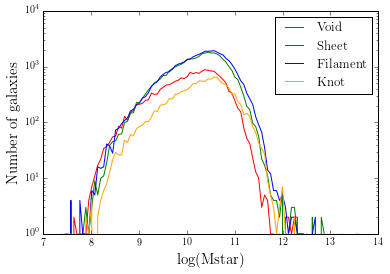

In [5]:
# Creating the log(Mstar) histogram (needed for the mstarweight)

nbins = 100
logmstarbins, logmstarhists, logmstarhistcens = \
envutils.create_histogram('log(Mstar)', logmstarlist, nbins, envnames, envlist, 'lin', False, False, False)

print 

In [6]:
# Calculate the logmstar weight for each galaxy

# Create the average histogram
avhist = np.mean(logmstarhists, 0)

# Calculate the weight for each logmstar bin
weighthists = avhist/logmstarhists
weighthists[np.logical_not(np.isfinite(weighthists))] = 0

weightlist = np.zeros(len(logmstarlist)) # Length of the merged GAMA catalog

for env in xrange(len(envnames)): # For each environment
    envname = envnames[env]
    envmask = (envlist == env) # Mask the lenses outside that environment
    for b in xrange(nbins): # For each logmstar bin
        binmask = (logmstarbins[b]<=logmstarlist) & (logmstarlist<logmstarbins[b+1]) # Mask the lenses outside that bin
        totmask = envmask & binmask
        weight = weighthists[env,b]
        #print 'Env: %s, Bin: %i, Weight: %g'%(envname, b, weight)
        weightlist[totmask] = weight

/software/local/lib64/python2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/software/local/lib64/python2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


In [7]:
# Print the logmstarweight to a fits file
weightlist_tot = np.zeros(len(galIDlist))
weightlist_tot[obsmask] = weightlist


filename = '%s/mstarweight_rank%g-%g.fits'%(path_results, rankmin, rankmax)
if shuffled:
    filename = filename.replace('.fits', '_shuffled.fits')

envutils.write_catalog(filename, galIDlist, ['mstarweight'], [weightlist_tot])


Old catalog overwritten: results/mstarweight_rank-999-inf.fits



environment_utils.py:290: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
  tbhdu = pyfits.new_table(cols)


The weights are: [ 1.45083933  1.37180307  1.32385321 ...,  1.45083933  1.37180307
  1.32385321]
The weights are: [ 0.74277457  0.71260306  0.71160221 ...,  0.71386306  0.71386306
  0.76079545]
The weights are: [ 0.67269824  0.66965227  0.65610329 ...,  0.67269824  0.74131514
  0.67050439]
The weights are: [ 2.62621359  2.2820197   2.62621359 ...,  2.2080292   2.01523297
  2.27887324]


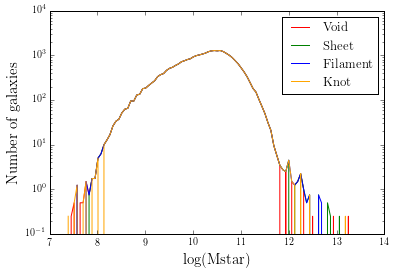

In [8]:
logmstarbins, logmstarhists, logmstarhistcens = envutils.create_histogram('log(Mstar)',logmstarlist, nbins, envnames, envlist, 'lin', False, weightlist, False)

In [9]:



# Repeating AngSep and average quantity calculations for weighted galaxies

In [10]:
# Calculating average redshift, log(M*) and satellite fraction of the lens samples (needed for halo model)

if shuffled:
    print 'For the shuffled environments:'
else:
    print 'For the cosmic environments:'
print 

print 'Without logmstarweight:'
zaverage, mstaraverage, fsat, fsatmax = envutils.calc_halomodel_input(envnames, envlist, ranklist, zlist, mstarlist, False)


print
print 'With logmstarweight:'
zaverage, mstaraverage, fsat, fsatmax = envutils.calc_halomodel_input(envnames, envlist, ranklist, zlist, mstarlist, weightlist)

For the cosmic environments:

Without logmstarweight:
               ['Void', 'Sheet', 'Filament', 'Knot']
average(Z): 0.160925537348,0.169397339225,0.165214344859,0.156667143106,
average(M*): 27674542080.0,34645168128.0,39450468352.0,43540471808.0,
minimum fsat: 0.146489717354,0.242987451229,0.362991880823,0.502266478413,
maximum fsat: 0.900871238983,0.866577032585,0.849088688238,0.848628966337,

With logmstarweight:
               ['Void', 'Sheet', 'Filament', 'Knot']
average(Z): 0.168767958879,0.168844237924,0.163049921393,0.154133737087,
average(M*): 34973622272.0,35387187200.0,35234938880.0,35052064768.0,
minimum fsat: 0.138217471922,0.242073486916,0.366008027249,0.508988595418,
maximum fsat: 0.881776569305,0.863308940277,0.858628853151,0.865495594939,


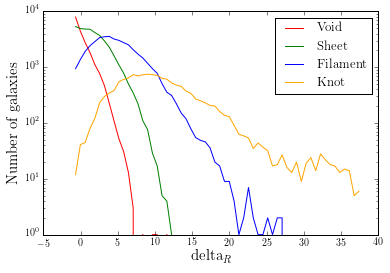

Written: ESD profile plot: environment_deltaR_histogram.pdf


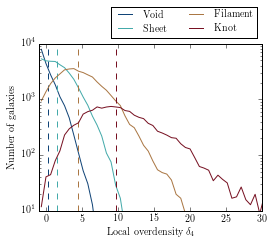

In [11]:
# Plot delta_R

nbins = 60
deltaRbins, deltaRhists, deltaRhistcens = \
envutils.create_histogram('delta_R', deltaRlist, nbins, envnames, envlist, 'lin', False, False, False)

plt.show()
plt.close()

###############################

# Show results
plt.figure(1, figsize=(4, 3))


for env in xrange(len(envnames)):
    plt.plot(deltaRhistcens, deltaRhists[env], '', ls='-', color=envcolors[env], label=envnames[env])
    plt.axvline(x = np.median(deltaRlist[envlist==env]), linestyle='--', color=envcolors[env])
    
plt.xlim(-1, 30)
plt.ylim(1e1, 1e4)

plt.yscale('log')
lgd = plt.legend(fontsize = 10, bbox_to_anchor=(1.0, 1.25), ncol=2)

xlabel = 'Local overdensity $\delta_{\r 4}$'
#ylabel = 'Number of galaxies'
ylabel = 'Number of galaxies'


plt.ylabel(r'%s'%ylabel)
plt.xlabel(r'%s'%xlabel)

histname = 'environment_deltaR_histogram'
if shuffled:
    histname = '%s_shuffled'%(histname)

plotname = '%s.pdf'%histname

plt.savefig(plotname, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
print 'Written: ESD profile plot:', plotname
   
plt.show()

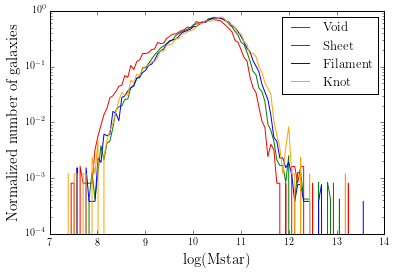

Written: ESD profile plot: environment_logmstar_histogram.pdf


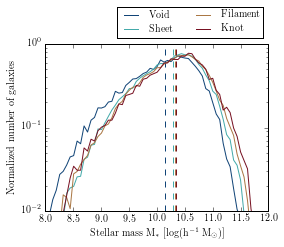

In [12]:
# Creating the log(Mstar) histogram (needed for the mstarweight)

nbins = 100
logmstarbins, logmstarhists, logmstarhistcens = \
envutils.create_histogram('log(Mstar)', logmstarlist, nbins, envnames, envlist, 'lin', 1, False, False)

plt.show()
plt.close()

#####################

# Show results
plt.figure(1, figsize=(4, 3))
#plt.plot(logmstarhistcens, avhist, '', ls='-', color='black', label='Average')

for env in xrange(len(envnames)):
    plt.plot(logmstarhistcens, logmstarhists[env], '', ls='-', color=envcolors[env], label=envnames[env])
    plt.axvline(x = np.median(logmstarlist[envlist==env]), linestyle='--', color=envcolors[env])
    
plt.xlim(8, 12)
plt.ylim(1e-2, 1e0)

plt.yscale('log')

lgd = plt.legend(fontsize = 10, bbox_to_anchor=(1.0, 1.25), ncol=2)

xlabel = r'Stellar mass M$_*$ [log(h$^{-1}$ M$_\odot$)]'
#ylabel = 'Number of galaxies'
ylabel = 'Normalized number of galaxies'


plt.ylabel(r'%s'%ylabel)
plt.xlabel(r'%s'%xlabel)

histname = 'environment_logmstar_histogram'
if shuffled:
    histname = '%s_shuffled'%(histname)

plotname = '%s.pdf'%histname

plt.savefig(plotname, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
print 'Written: ESD profile plot:', plotname
   
plt.show()


[[ 0.39729565  0.22492289  0.07719576  0.01085179]
 [ 0.42945407  0.42762239  0.28983737  0.08406422]
 [ 0.16656538  0.31695358  0.49244329  0.43697042]
 [ 0.00648233  0.03047478  0.14057148  0.46833655]]


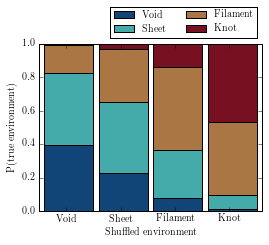

Written: shuffenv_plots/shuffled_proportion_histogram_S4_deltaR4.pdf


In [13]:
# Plot fraction of true environment in each shuffled environment

fig, ax = plt.subplots(figsize=(4, 3))

envnumbers = np.arange(4)
envbins = np.append(envnumbers, 4)
shuffenvhist = np.zeros([4,4])
shuffenvhist_cum = np.zeros([4,4])

shuffenvmasks = [(shuffenvlist == env) for env in envnumbers]
shuffenvnums = np.array([np.sum(shuffenvmasks, 1)]*4, dtype='float')

for env in envnumbers:
    
    realenvlist = envlist[shuffenvmasks[env]]

    histvalues, histbins = np.histogram(realenvlist, bins=envbins)

    shuffenvhist[env] = histvalues
    
shuffenvhist = shuffenvhist/shuffenvnums
print shuffenvhist


for env in np.arange(3):
    shuffenvhist_cum[env+1] = np.sum(shuffenvhist[0:env+1], 0)


for env in envnumbers:
    plt.bar(envnumbers, shuffenvhist[env], width = 0.9, color = envcolors[env], \
            label=envnames[env], bottom = shuffenvhist_cum[env])
    
ax.set_xticks(envnumbers+0.4)
ax.set_xticklabels(envnames)

plt.xlim(-0.1, 4)
plt.ylim(0., 1.)

plt.ylabel(r'P(true environment)')
plt.xlabel(r'Shuffled environment')

lgd = plt.legend(fontsize = 10, bbox_to_anchor=(1.0, 1.25), ncol=2)

plotname = 'shuffenv_plots/shuffled_proportion_histogram_S4_deltaR4.pdf'
plt.savefig(plotname, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

print 'Written:', plotname


9048 9048
Written: shuffenv_plots/volume_limited_sample.pdf


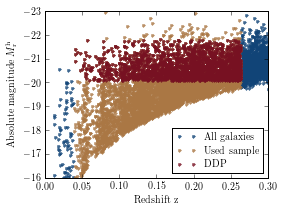

In [27]:
zmin = 0.039
zmax = 0.263

galZlist =  (gamacat['Z'])[1::20]
galmaglist = maglist[1::20]

print len(galZlist), len(galmaglist)

lensmask = (zmin<galZlist)&(galZlist<zmax)#&(nQlist>=3)&(complist>0.8)
DDPmask = (lensmask)&(-21.8<galmaglist)&(galmaglist<-20.1)
samplemask = np.logical_not(lensmask)

fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(galZlist[samplemask], galmaglist[samplemask], '.', alpha=0.8, color=envcolors[0], label='All galaxies')
plt.plot(galZlist[lensmask], galmaglist[lensmask], '.', alpha=0.8, color=envcolors[2], label='Used sample')
plt.plot(galZlist[DDPmask], galmaglist[DDPmask], '.', alpha=0.8, color=envcolors[3], label='DDP')

plt.xlabel(r'Redshift z')
plt.ylabel(r'Absolute magnitude $M^{\rm h}_{\rm r}')

plt.gca().invert_yaxis()
plt.legend(fontsize = 10, loc='best')

plt.xlim(0.0, 0.3)
plt.ylim(-16, -23)

plotname = 'shuffenv_plots/volume_limited_sample.pdf'
plt.savefig(plotname, format='pdf', bbox_inches='tight')

print 'Written:', plotname

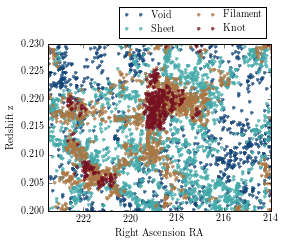

In [28]:
zlims = [0.2, 0.23]
RAlims = [214, 223.5]

galRAlist =  RAlist[1::10]
galDEClist = DEClist[1::10]

fig, ax = plt.subplots(figsize=(4, 3))

for env in xrange(len(envnames)): # For each environment

    envmask = (envlist == env) # Mask the lenses outside that environment
    
    plt.plot(RAlist[envmask], zlist[envmask], '.', alpha=0.8, color=envcolors[env], label=envnames[env])

plt.xlim(RAlims)
plt.ylim(zlims)    

plt.ylabel(r'Redshift z')
plt.xlabel(r'Right Ascension RA')

plt.gca().invert_xaxis()

lgd = plt.legend(fontsize = 10, bbox_to_anchor=(1.0, 1.25), ncol=2)

plotname = 'shuffenv_plots/environments.pdf'
plt.savefig(plotname, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')